Вариант 19: 
*Hierarchical text classification*

**исходные**: text

**прогнозные**: cat1

url: https://www.kaggle.com/kashnitsky/hierarchical-text-classification

### Необходимые библиотеки

In [54]:
import numpy as np
import pandas as pd
import random

import collections
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import string
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.vocab import GloVe

In [55]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. Загрузить набор данных (Hierarchical text classification)

predict: text

feature: cat1

In [57]:
data = pd.read_csv('/content/drive/MyDrive/datasets/train_40k.csv')
data.head(3)

,productId,Title,userId,Helpfulness,Score,Time,Text,Cat1,Cat2,Cat3
0,B000E46LYG,Golden Valley Natural Buffalo Jerky,A3MQDNGHDJU4MK,0/0,3.0,-1,The description and photo on this product need...,grocery gourmet food,meat poultry,jerky
1,B000GRA6N8,Westing Game,unknown,0/0,5.0,860630400,This was a great book!!!! It is well thought t...,toys games,games,unknown
2,B000GRA6N8,Westing Game,unknown,0/0,5.0,883008000,"I am a first year teacher, teaching 5th grade....",toys games,games,unknown


In [58]:
data = data[['Text','Cat1']]
data.head(3)

,Text,Cat1
0,The description and photo on this product need...,grocery gourmet food
1,This was a great book!!!! It is well thought t...,toys games
2,"I am a first year teacher, teaching 5th grade....",toys games


### Exploratory Data Analysis (EDA) on Text Data

**Analyzing text statistics**


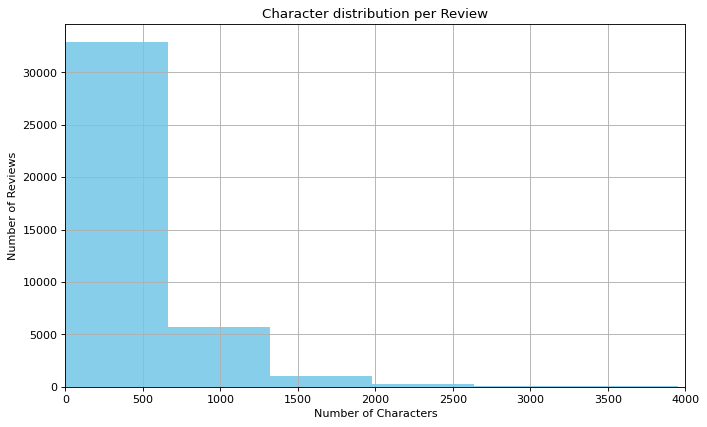

The histograms shows that reviews range from 0 to ~4000. Mostly, it is between 0 and ~600 characters per review.


In [ ]:
# кол-во символов в одном отзыве

figure(figsize=(10, 6), dpi=80)
data.Text.str.len().hist(color = "skyblue")
plt.xlim([0, 4000])
plt.xlabel("Number of Characters")
plt.ylabel("Number of Reviews")
plt.title("Character distribution per Review")
plt.show()
print('The histograms shows that reviews range from 0 to ~4000. Mostly, it is between 0 and ~600 characters per review.')

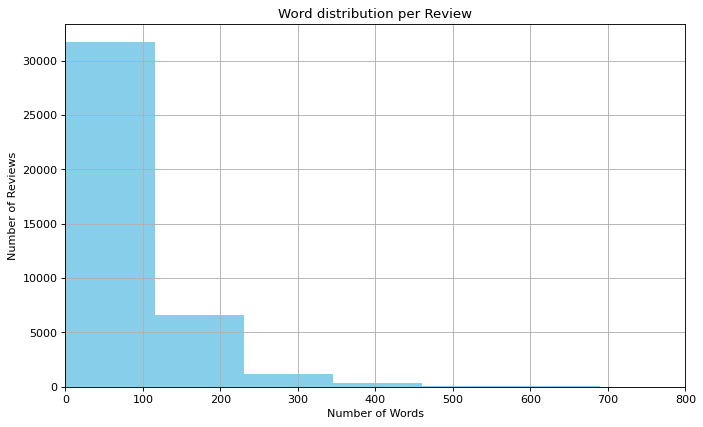

The histograms shows that reviews range from 0 to almost 700 words. Mostly, it is between 0 and 100 words per review.


In [ ]:
# next level: word-analysis
# количество слов в отзыве

figure(figsize=(10, 6), dpi=80)
data.Text.str.split().apply(lambda x: len(x)).hist(color = 'skyblue')
plt.xlim([0, 800])
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.title("Word distribution per Review")
plt.show()
print('The histograms shows that reviews range from 0 to almost 700 words. Mostly, it is between 0 and 100 words per review.')

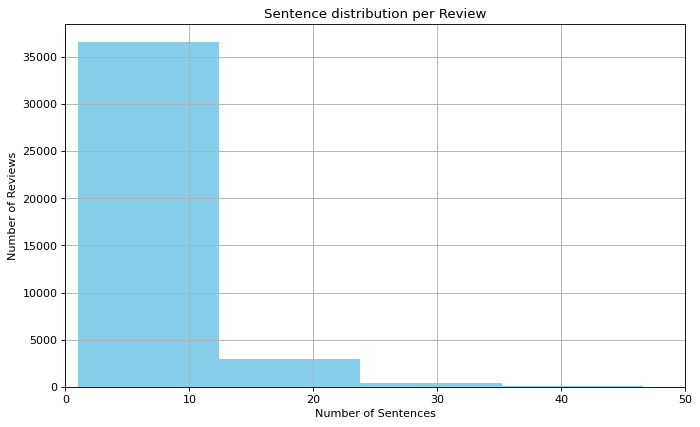

The histograms shows that reviews range from 0 to almost 50 sentences. Mostly, it is between 0 and 10 words per review.


In [ ]:
# next level: sentence-analysis
# кол-во предложений в отзыве

figure(figsize=(10, 6), dpi=80)
data.Text.str.split('.').apply(lambda x: len(x)).hist(color = 'skyblue')
plt.xlim([0, 50])
plt.xlabel("Number of Sentences")
plt.ylabel("Number of Reviews")
plt.title("Sentence distribution per Review")
plt.show()
print('The histograms shows that reviews range from 0 to almost 50 sentences. Mostly, it is between 0 and 10 sentences per review.')

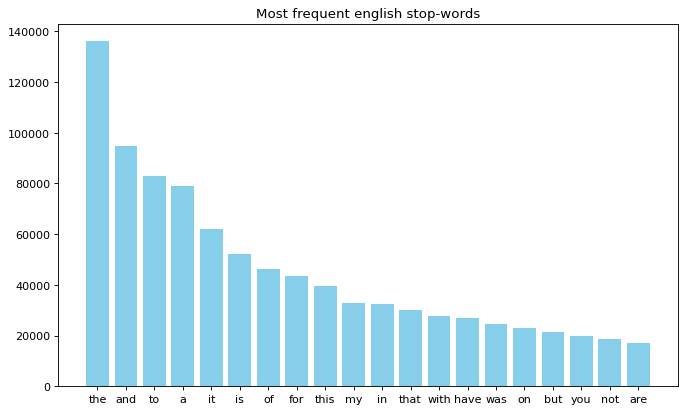

In [ ]:
# распределение стоп-слов 
stop = set(stopwords.words('english'))
corpus = []
temp = data.Text.str.split().values.tolist()

corpus = [word for i in temp for word in i]
dict_sw = defaultdict(int)
for word in corpus:
    if word in stop:
        dict_sw[word] += 1


stop_words = sorted(dict_sw.items(), key = lambda x: x[1], reverse = True) # sorted by frequency
top_sw = stop_words[:20] # top 20


word = []
frequency = []
for i in range(len(top_sw)):
  word.append(top_sw[i][0])
  frequency.append(top_sw[i][1])

figure(figsize=(10, 6), dpi=80)
plt.bar(word, frequency, color='skyblue')
plt.title("Most frequent english stop-words")
plt.show()


In [ ]:
# распределение слов по частоте в каждой отдельной категории

c1 = data.loc[data['Cat1'] == 'health personal care']
c1_corpus = []
temp = c1.Text.str.lower().str.split().values.tolist()
c1_corpus = [word for i in temp for word in i]

c2 = data.loc[data['Cat1'] == 'toys games']
c2_corpus = []
temp = c2.Text.str.lower().str.split().values.tolist()
c2_corpus = [word for i in temp for word in i]

c3 = data.loc[data['Cat1'] == 'beauty']
c3_corpus = []
temp = c3.Text.str.lower().str.split().values.tolist()
c3_corpus = [word for i in temp for word in i]

c4 = data.loc[data['Cat1'] == 'pet supplies']
c4_corpus = []
temp = c4.Text.str.lower().str.split().values.tolist()
c4_corpus = [word for i in temp for word in i]

c5 = data.loc[data['Cat1'] == 'baby products']
c5_corpus = []
temp = c5.Text.str.lower().str.split().values.tolist()
c5_corpus = [word for i in temp for word in i]

c6 = data.loc[data['Cat1'] == 'grocery gourmet food']
c6_corpus = []
temp = c6.Text.str.lower().str.split().values.tolist()
c6_corpus = [word for i in temp for word in i]


**Lets look at toys games as an example:**


Text(0.5, 1.0, 'Most frequent words in toys category')

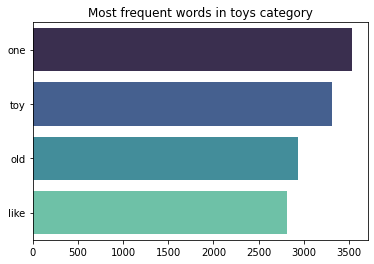

In [ ]:
c2_counter = collections.Counter(c2_corpus)
most_freq = c2_counter.most_common()

x, y = [], []
for word, count in most_freq[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)

sns.barplot(x = y,y = x, palette = 'mako').set_title('Most frequent words in toys category')

**And health personal care**

Text(0.5, 1.0, 'Most frequent words in health personal care category')

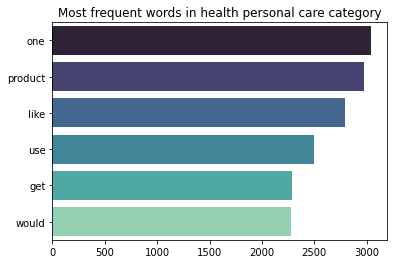

In [ ]:
c1_counter = collections.Counter(c1_corpus)
most_freq = c1_counter.most_common()

x, y = [], []
for word, count in most_freq[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)

sns.barplot(x = y,y = x, palette = 'mako').set_title('Most frequent words in health personal care category')

### Exploratory Data Analysis (EDA) on Target Data

In [ ]:
data.Cat1.isnull().sum()

0

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

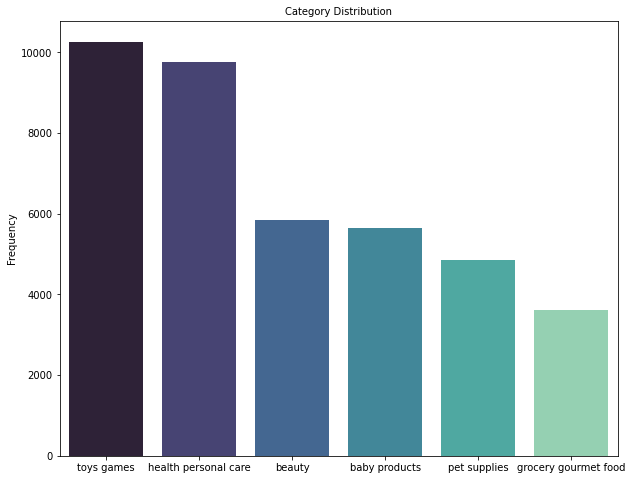

In [ ]:
x_cat = data.Cat1.value_counts()
y_cat = x_cat.sort_index()

plt.figure(figsize=(10,8))
sns.barplot(x_cat.index, x_cat.values, palette = 'mako')
plt.title("Category Distribution", fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.yticks(fontsize=10)

plt.xticks(fontsize=10)

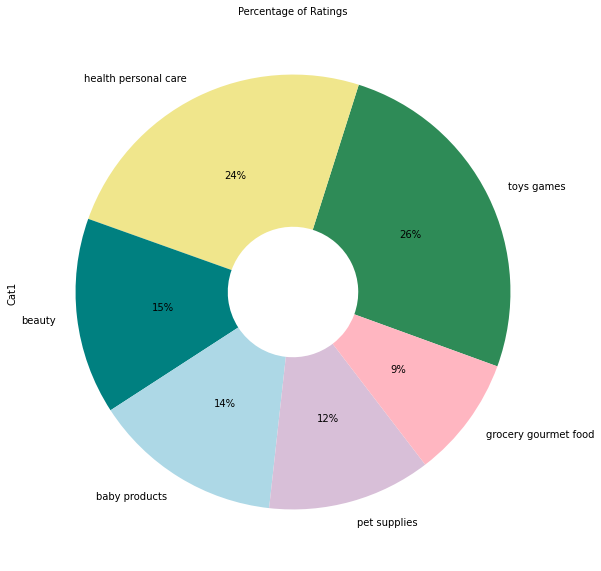

In [ ]:
plt.figure(figsize=(30,10))
plt.title('Percentage of Ratings', fontsize = 10)
colours = ['seagreen','khaki','teal','lightblue','thistle','lightpink']
data.Cat1.value_counts().plot(kind='pie', labels=['toys games', 'health personal care', 'beauty', 'baby products', 'pet supplies','grocery gourmet food'],
                               wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                               textprops={'fontsize': 10},colors =colours)

### Text preprocessing

In [59]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  #numbers
    text = re.sub(' +', ' ', text)
    text = re.sub('@[^\s]+', ' ', text)
    text = re.sub('[^a-zA-z]+', ' ', text)
    
    return text.strip() #white space 

data_prep = [preprocess_text(t) for t in data.Text]

In [60]:
# stop-words 
stop_words = set(stopwords.words('english'))
#ps = PorterStemmer()

def nltk_preprocess_text(text):
    tokens = word_tokenize(text)
    filtered_tokens = []
    for token in tokens:
      if token not in stop_words:
        filtered_tokens.append(token)
          #filtered_tokens.append(ps.stem(token))
    text = " ".join(filtered_tokens)
    return text

data_prep_ = [nltk_preprocess_text(t) for t in data_prep]

In [61]:
d = {'clean_text': data_prep_, 'cat': data.Cat1.values}
df = pd.DataFrame(d)
df.head(5)

,clean_text,cat
0,description photo product needs changed indica...,grocery gourmet food
1,great book well thought easily imagine events ...,toys games
2,first year teacher teaching th grade special r...,toys games
3,got book bookfair school looking something sum...,toys games
4,hi martine redman created puzzle briarpatch us...,toys games


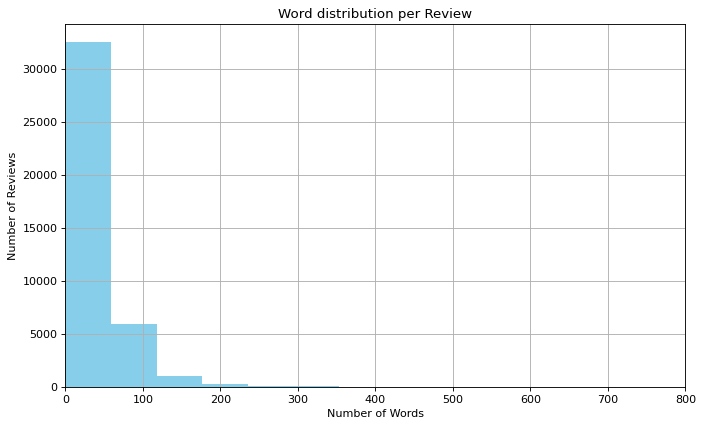

In [62]:
# количество слов в отзывах (обработанных)

figure(figsize=(10, 6), dpi=80)
df.clean_text.str.split().apply(lambda x: len(x)).hist(color = 'skyblue')
plt.xlim([0, 800])
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.title("Word distribution per Review")
plt.show()

In [92]:
# при первом создании словаря, было сказано мол max_seq_len 500 с чем-то, но в основном там копейки 
print('В среднем:', df.clean_text.str.split().apply(lambda x: len(x)).mean())
print('>500:', df.clean_text.str.split().apply(lambda x: len(x) > 500).sum()) 
print('>300:', df.clean_text.str.split().apply(lambda x: len(x) > 300).sum())
print('>100:', df.clean_text.str.split().apply(lambda x: len(x) > 100).sum())

В среднем: 38.11266294227188
>500: 0
>300: 0
>100: 1868


In [93]:
false_count = [i for i, x in enumerate(df.clean_text.str.split().apply(lambda x: len(x) > 100)) if x]
df = df.drop(false_count)
df = df.reset_index(drop=True)

### LabelEncoder + undersampling который не помог

In [94]:
lst = df.cat.unique()
le = LabelEncoder()
le.fit(lst)
for i in range(len(df)):
  df.cat[i] = le.transform([df.cat[i]]).item()


In [99]:
df.head(5)

,clean_text,cat
0,description photo product needs changed indica...,2
1,great book well thought easily imagine events ...,5
2,first year teacher teaching th grade special r...,5
3,got book bookfair school looking something sum...,5
4,hi martine redman created puzzle briarpatch us...,5


In [100]:
# андерсемплинг 
print('0', df.cat.apply(lambda x: x == 0).sum())
print('1', df.cat.apply(lambda x: x == 1).sum())
print('2', df.cat.apply(lambda x: x == 2).sum())
print('3', df.cat.apply(lambda x: x == 3).sum())
print('4', df.cat.apply(lambda x: x == 4).sum())
print('5', df.cat.apply(lambda x: x == 5).sum())

df1 = df
df_0 = df1.loc[df1['cat'] == 0].iloc[:3600]
df_1 = df1.loc[df1['cat'] == 1].iloc[:3600]
df_2 = df1.loc[df1['cat'] == 2].iloc[:3600]
df_3 = df1.loc[df1['cat'] == 3].iloc[:3600]
df_4 = df1.loc[df1['cat'] == 4].iloc[:3600]
df_5 = df1.loc[df1['cat'] == 5].iloc[:3600]

df_over = pd.concat([df_0,df_1,df_2,df_3,df_4, df_5], ignore_index=True)



0 5294
1 5583
2 3497
3 9195
4 4540
5 9761


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

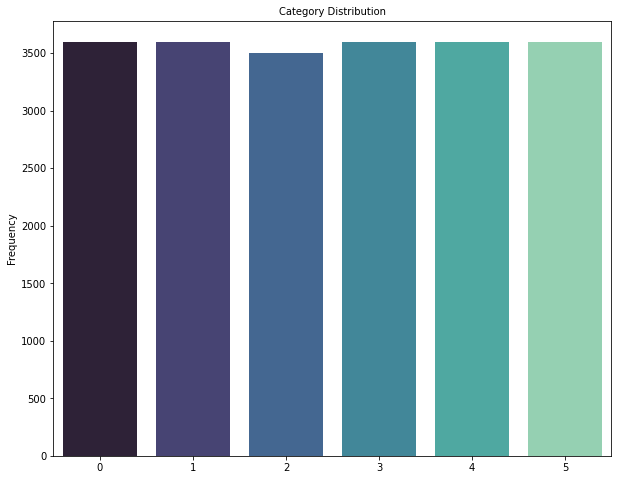

In [101]:
x_cat = df_over.cat.value_counts()
y_cat = x_cat.sort_index()

plt.figure(figsize=(10,8))
sns.barplot(x_cat.index, x_cat.values, palette = 'mako')
plt.title("Category Distribution", fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.yticks(fontsize=10)

plt.xticks(fontsize=10)

In [102]:
len(df_over)

21497

### Train test split

In [103]:
x = df.clean_text.values
y = df.cat.values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, random_state = 42)
print("Training Data: ", len(x_train))
print("Testing Data: ", len(x_test))

Training Data:  30296
Testing Data:  7574


### Vocabulary

In [105]:
class Vocab:
  def __init__(self, data):
    tokens = set()
    self.max_seq_len = 0
    for review in data:
      tokens.update(word_tokenize(review))
       
    self.idx_to_token = {(idx+1): token for idx, token in enumerate(tokens)}

    self.idx_to_token[0] = '<PAD>'
    self.idx_to_token[len(self.idx_to_token)] = '<UNK>'

    self.token_to_idx = {token: idx for idx, token in self.idx_to_token.items()}


    self.vocab_len = len(self.idx_to_token)
    temp = [len(word_tokenize(i)) for i in data]
    self.max_seq_len = max(temp)+2

In [106]:
vocab = Vocab(x_train)

In [107]:
print('Max_seq_len: ', vocab.max_seq_len)
print('Vocabulary length: ', vocab.vocab_len)

Max_seq_len:  102
Vocabulary length:  36692


### Datasets

In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, X, y, vocab):
        self.X = X 
        self.y = y 
        self.vocab = vocab 

    def vectorize(self, review): 
        review_t = torch.zeros(self.vocab.max_seq_len).long()
        
        for i, word in enumerate(word_tokenize(review)): 
            if i <= self.vocab.max_seq_len:
                if word in list(vocab.token_to_idx.keys()):
                    review_t[i] = self.vocab.token_to_idx[word]
                else:
                    review_t[i] = self.vocab.token_to_idx["<UNK>"]
        return review_t

    def __getitem__(self, idx):
        return self.vectorize(self.X[idx]), torch.tensor(self.y[idx])

    def __len__(self):
        return len(self.X)

In [ ]:
ReviewDataset(x_train, y_train, vocab)[1]

(tensor([12641, 12014, 24971, 18781, 19982, 34521, 15497, 10930, 29799, 35088,
         34503, 32705, 24971, 35474, 35847,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [ ]:
# basic params

embed_dim = 200
max_features = vocab.vocab_len # num rows in embedding vector (unique words) = vocab.vocab_len
maxlen = vocab.max_seq_len # max number of words to use
batch_size = 128 # samples per process at once
n_epochs = 5

In [ ]:
review_train = ReviewDataset(x_train, y_train, vocab)
review_test = ReviewDataset(x_test, y_test, vocab)

r_dataloader_train = DataLoader(review_train, batch_size = batch_size, shuffle = True)
r_dataloader_test = DataLoader(review_test, batch_size = batch_size, shuffle = True)

### Используемые функции. Параметры

In [146]:
def conf_matrix(model, r_dataloader_test, nb_classes, is_gru = False):
   correct1, total1 = 0, 0
   confusion_matrix = torch.zeros(nb_classes, nb_classes)
   with torch.no_grad():
      for i, (inputs, classes) in enumerate(r_dataloader_test):
          inputs = inputs
          classes = classes

          if is_gru == True:
            outputs, h = model(inputs.long())
          else:
            outputs = model(inputs.long())

          _, preds = torch.max(outputs, 1)
          total1 += classes.shape[0]
          correct1 += int((preds == classes).sum())
          for t, p in zip(classes.view(-1), preds.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1

   print(f'Test Accuracy: {correct1 / total1}')
   cm = confusion_matrix
   plt.figure(figsize=(12, 6))

   tick = le.classes_
   ax = sns.heatmap(cm, annot=True, fmt="f", linewidths=.5, cmap="YlGnBu", xticklabels = tick, yticklabels = tick)
   plt.xlabel("actual values") 
   plt.ylabel("predicted values") 

   return cm

In [147]:
def train_model(model, dataloader, loss, optimizer, n_epochs, is_gru = False):
    losses = []
    for epoch in range(n_epochs):
      for x_batch, y_batch in dataloader:
        
        x_batch = x_batch.long()
        y_batch = y_batch.long()

        if is_gru == True:
          out, h = model(x_batch)
        else:
          out = model(x_batch)

        # loss
        batch_loss = loss(out, y_batch)

        # backward
        batch_loss.backward()

        # optimization
        curr_loss = []
        optimizer.step()
        optimizer.zero_grad()
        curr_loss.append(batch_loss.item())
      losses.append(np.mean(curr_loss))

      print(f"Epoch: {epoch}, loss: {losses[-1]}")

    return losses



### Classification Model 1 (without convolutional and recurrent layers)

In [ ]:
class First_model(nn.Module):
    def __init__(self, *args):
        super().__init__()

        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_dim)

        self.layer = nn.Sequential(
            
            nn.Flatten(),
            
            nn.Linear(embed_dim*maxlen, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            
            nn.Linear(32, n_classes),
        )
    
    def forward(self, input):
        #print(input.shape)
        input = self.embedding(input)
        #print(input.shape)
        input = input.unsqueeze(1)
        #print(input.shape)
        input = self.layer(input)
        return input

In [ ]:
# train model
model_first = First_model()

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_first.parameters(), lr = 0.001)
losses = []

for epoch in range(n_epochs):
  for x_batch, y_batch in r_dataloader_train:
    
    x_batch = x_batch.long()
    y_batch = y_batch.long()
    out = model_first(x_batch)

    # loss
    batch_loss = loss(out, y_batch)

    # backward
    batch_loss.backward()

    # optimization
    curr_loss = []
    optimizer.step()
    optimizer.zero_grad()
    curr_loss.append(batch_loss.item())
  losses.append(np.mean(curr_loss))

  print(f"Epoch: {epoch}, loss: {losses[-1]}")

Epoch: 0, loss: 1.311205506324768
Epoch: 1, loss: 1.25496506690979
Epoch: 2, loss: 0.7881628274917603
Epoch: 3, loss: 0.6086218357086182
Epoch: 4, loss: 0.5135337710380554
Epoch: 5, loss: 0.23874083161354065
Epoch: 6, loss: 0.22656001150608063
Epoch: 7, loss: 0.3350644111633301
Epoch: 8, loss: 0.09635721892118454
Epoch: 9, loss: 0.11362498998641968


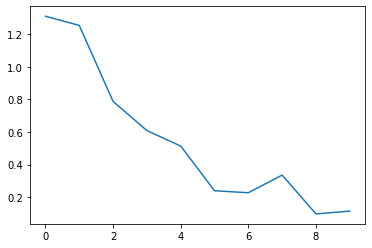

In [ ]:
plt.plot(losses)

In [ ]:
# Test Accuracy
correct1, total1 = 0, 0
with torch.no_grad():
  for review, labels in r_dataloader_test:
    batch_size = review.shape[0]

    out = model_first(review.view(batch_size, -1).long())
    _, predicted = torch.max(out, dim=1)

    total1 += labels.shape[0]
    correct1 += int((predicted == labels).sum())
print(f'Test Accuracy: {correct1 / total1}')

Test Accuracy: 0.7502516356316055


tensor([0.6156, 0.5106, 0.6996, 0.9008, 0.7758, 0.8728])
['baby products' 'beauty' 'grocery gourmet food' 'health personal care'
 'pet supplies' 'toys games']


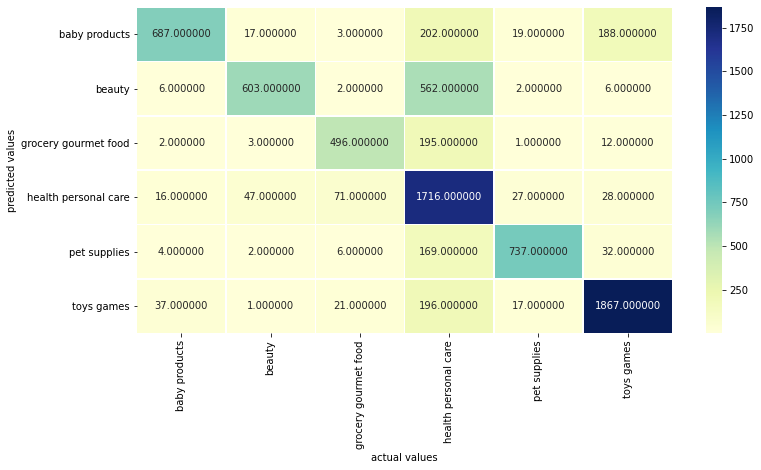

In [ ]:
nb_classes = len(le.classes_)
cm = conf_matrix(model, r_dataloader_test, nb_classes)
print(cm.diag()/cm.sum(1)) #per-class accuracy
print(le.classes_)

### Classification Model 2. CNN

In [ ]:
# torch.nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, 
#                 padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')

class CNN(nn.Module):
    
    def __init__(self, *args):
        super().__init__()

        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_dim)
        self.dropout = nn.Dropout(0.1)

        self.conv1 = nn.Sequential(
            nn.Conv1d(embed_dim, 100, 5),    
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.MaxPool1d(2),                                           
        )

        self.conv2 = nn.Sequential(
            nn.Conv1d(100, 500, 5),    
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.MaxPool1d(2),                                           
        )

        self.layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(500*47, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            
            nn.Linear(32, n_classes),
        )
                                          
    def forward(self, x): 
        #print(x.shape)
        out = self.embedding(x)
        #print(out.shape) 
        out = out.permute(0,2,1)
        #print(out.shape) 
        out = self.conv1(out)
        #print(out.shape) 
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.dropout(out)
        out = self.layer(out)
        return out

In [ ]:
# train model

model_CNN = CNN()
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_CNN.parameters(), lr = 0.001)
losses = []

for epoch in range(n_epochs):
  for x_batch, y_batch in r_dataloader_train:
    
    x_batch = x_batch.long()
    y_batch = y_batch.long()

    out = model_CNN(x_batch)

    # loss
    batch_loss = loss(out, y_batch)

    # backward
    batch_loss.backward()

    # optimization
    curr_loss = []
    optimizer.step()
    optimizer.zero_grad()
    curr_loss.append(batch_loss.item())
  losses.append(np.mean(curr_loss))

  print(f"Epoch: {epoch}, loss: {losses[-1]}")

Epoch: 0, loss: 1.012546420097351
Epoch: 1, loss: 0.8050436973571777
Epoch: 2, loss: 0.6711949706077576
Epoch: 3, loss: 0.49260106682777405
Epoch: 4, loss: 0.3132501542568207


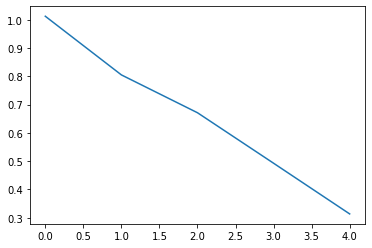

In [ ]:
plt.plot(losses)

In [ ]:
# PATH = "state_dict_model.pt"
# torch.save(model.state_dict(), PATH)

# Load
# model_loaded = torch.load(PATH)


In [ ]:
# Load
# model_loaded = torch.load(PATH)

Test Accuracy: 0.7862355309511827
tensor([0.7746, 0.7494, 0.7205, 0.7546, 0.7858, 0.8640])
['baby products' 'beauty' 'grocery gourmet food' 'health personal care'
 'pet supplies' 'toys games']


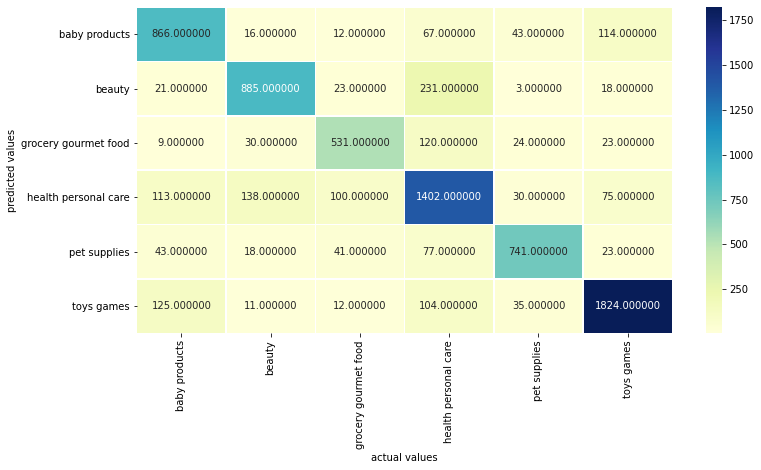

In [ ]:
nb_classes = len(le.classes_)
cm = conf_matrix(model_CNN, r_dataloader_test, nb_classes, is_gru = False)
print(cm.diag()/cm.sum(1)) #per-class accuracy
print(le.classes_)

Using the matrix attached in the question and considering the values in the vertical axis as the actual class, and the values in the horizontal axis the prediction. Then for the Class 1:

- **True Positive** = 904 -> samples of class 1, classified as class 1
- **False Positive** = 247 (29+10+97+31+80) samples of 2, 3, 4, 5, 6 but classified as class 1
- **False Negative** = 212 -> (37+2+26+19+128) samples of class 1, but classified as classes 2, 3, 4, 5, 6
- **Ture Negative** = (много считать) The sum of all the values in the matrix except those in column 1 and row 1

Accuracy: (TP+TN)/(TP+TN+FP+FN).

### Classification Model 3. GRU

In [ ]:
class GRU(nn.Module):
    def __init__(self, *args):
        super().__init__()

        n_classes = len(le.classes_)
        hid = 64
        self.embedding = nn.Embedding(max_features, embed_dim)

        self.gru = nn.GRU(embed_dim, hid, num_layers = 1, batch_first = True)  # batch_first – If True, then the input and output tensors are provided as (batch, seq, feature).
        
        self.layer1 = nn.Sequential(
            nn.Linear(hid, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, n_classes),

        )

    def forward(self, x):
        out = self.embedding(x)
        out, h = self.gru(out)
        out = self.layer1(out[:,-1])  

        
        return out, h


In [ ]:
# train model
model = GRU()
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)
losses = []

n_epochs = 5
for epoch in range(n_epochs):
  for x_batch, y_batch in r_dataloader_train:
    
    x_batch = x_batch.long()
    y_batch = y_batch.long()
    out, hidden = model(x_batch)

    # loss
    batch_loss = loss(out, y_batch)

    # backward
    batch_loss.backward()

    # optimization
    curr_loss = []
    optimizer.step()
    optimizer.zero_grad()
    curr_loss.append(batch_loss.item())
  losses.append(np.mean(curr_loss))

  print(f"Epoch: {epoch}, loss: {losses[-1]}")


Epoch: 0, loss: 1.208072304725647
Epoch: 1, loss: 0.7562702894210815
Epoch: 2, loss: 0.597273051738739
Epoch: 3, loss: 0.5819767117500305
Epoch: 4, loss: 0.5844075083732605


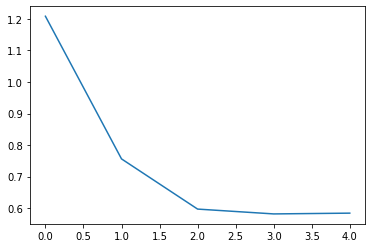

In [ ]:
plt.plot(losses)

In [ ]:
# Test Accuracy
correct1, total1 = 0, 0
with torch.no_grad():
  for review, labels in r_dataloader_test:
    batch_size = review.shape[0]

    out, hidden = model(review.long())
    _, predicted = torch.max(out, dim=1)

    total1 += labels.shape[0]
    correct1 += int((predicted == labels).sum())
print(f'Test Accuracy: {correct1 / total1}')

Test Accuracy: 0.7930296930045294


tensor([0.7782, 0.7341, 0.7001, 0.7740, 0.8155, 0.8730])
['baby products' 'beauty' 'grocery gourmet food' 'health personal care'
 'pet supplies' 'toys games']


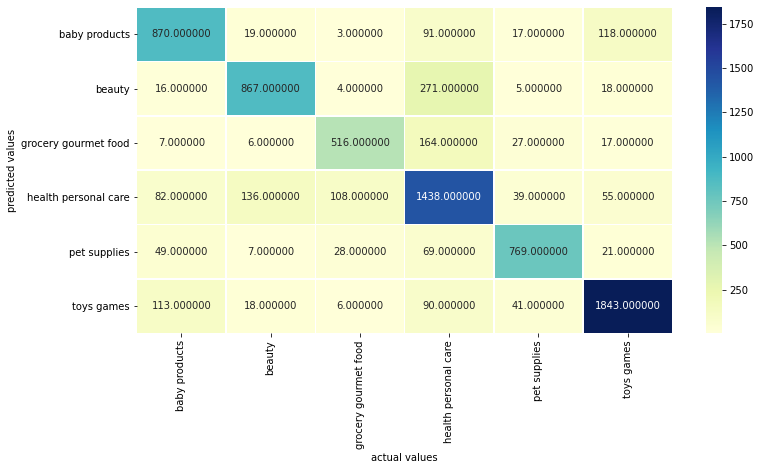

In [ ]:
nb_classes = len(le.classes_)
cm = conf_matrix(model, r_dataloader_test, nb_classes, is_gru = True)
print(cm.diag()/cm.sum(1)) #per-class accuracy
print(le.classes_)

### Glove + loaders

In [73]:
# stoi – A collections.defaultdict instance mapping token strings to numerical identifiers.
# itos – A list of token strings indexed by their numerical identifiers.

glove = GloVe(name = '6B', dim = 100, unk_init = torch.Tensor.normal_)

glove.stoi['<PAD>'] = len(glove.stoi)
glove.itos.append('<PAD>')

glove.stoi['<UNK>'] = len(glove.stoi)
glove.itos.append('<UNK>')

glove.vectors = torch.cat([glove.vectors, torch.zeros((2, 100))])

In [74]:
print(glove.stoi['the'])
print(glove['the'])

0
tensor([-0.0382, -0.2449,  0.7281, -0.3996,  0.0832,  0.0440, -0.3914,  0.3344,
        -0.5755,  0.0875,  0.2879, -0.0673,  0.3091, -0.2638, -0.1323, -0.2076,
         0.3340, -0.3385, -0.3174, -0.4834,  0.1464, -0.3730,  0.3458,  0.0520,
         0.4495, -0.4697,  0.0263, -0.5415, -0.1552, -0.1411, -0.0397,  0.2828,
         0.1439,  0.2346, -0.3102,  0.0862,  0.2040,  0.5262,  0.1716, -0.0824,
        -0.7179, -0.4153,  0.2033, -0.1276,  0.4137,  0.5519,  0.5791, -0.3348,
        -0.3656, -0.5486, -0.0629,  0.2658,  0.3020,  0.9977, -0.8048, -3.0243,
         0.0125, -0.3694,  2.2167,  0.7220, -0.2498,  0.9214,  0.0345,  0.4674,
         1.1079, -0.1936, -0.0746,  0.2335, -0.0521, -0.2204,  0.0572, -0.1581,
        -0.3080, -0.4162,  0.3797,  0.1501, -0.5321, -0.2055, -1.2526,  0.0716,
         0.7056,  0.4974, -0.4206,  0.2615, -1.5380, -0.3022, -0.0734, -0.2831,
         0.3710, -0.2522,  0.0162, -0.0171, -0.3898,  0.8742, -0.7257, -0.5106,
        -0.5203, -0.1459,  0.8278,  0.

In [75]:
class ReviewDataset(Dataset):
    def __init__(self, X, y, vocab):
        self.X = X 
        self.y = y 
        self.vocab = vocab 
        self.maxlen = 200

    def vectorize(self, review): 
        review_t = torch.zeros(self.maxlen).long()
        
        for i, word in enumerate(word_tokenize(review)): 
            if i <= self.maxlen:
              try:
                review_t[i] = self.vocab.stoi[word]
              except:
                review_t[i] = self.vocab.stoi['<UNK>']
        return review_t

    def __getitem__(self, idx):
        return self.vectorize(self.X[idx]), torch.tensor(self.y[idx])

    def __len__(self):
        return len(self.X)

In [76]:
# базовые параметры
max_features = len(glove)
maxlen = len(ReviewDataset(x_train, y_train, glove)[1][0])
embed_dim = 100
batch_size = 128 
n_epochs = 5

In [77]:
# без андерсемплинга 
review_train = ReviewDataset(x_train, y_train, glove)
review_test = ReviewDataset(x_test, y_test, glove)

r_dataloader_train = DataLoader(review_train, batch_size = batch_size)
r_dataloader_test = DataLoader(review_test, batch_size = batch_size)

In [78]:
# c 
x_ = df_over.clean_text.values
y_ = df_over.cat.values

x_train_, x_test_, y_train_, y_test_ = train_test_split(x_, y_, test_size = .2, random_state = 42)
print("Training Data: ", len(x_train_))
print("Testing Data: ", len(x_test_))


review_train_1 = ReviewDataset(x_train_, y_train_, glove)
review_test_1 = ReviewDataset(x_test_, y_test_, glove)

r_dataloader_train_1 = DataLoader(review_train_1, batch_size = batch_size)
r_dataloader_test_1 = DataLoader(review_test_1, batch_size = batch_size)

Training Data:  17280
Testing Data:  4320


### First model (pretrained_emb)

In [ ]:
class NN_pre(nn.Module):
    def __init__(self, *args):
        super().__init__()

        n_classes = len(le.classes_)
        self.maxlen = maxlen
        self.embedding = nn.Embedding(max_features, embed_dim)
        self.embedding = self.embedding.from_pretrained(glove.vectors)
        

        self.layer = nn.Sequential(
            
            nn.Flatten(),
            
            # nn.Linear(self.maxlen*embed_dim, 1024),
            # nn.ReLU(),
            # nn.Linear(1024, 512),
            # nn.ReLU(),
            nn.Linear(self.maxlen*embed_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            
            nn.Linear(64, n_classes),
        )
    
    def forward(self, input):
        #print(input.shape)
        input = self.embedding(input)
        #print(input.shape)
        input = input.unsqueeze(1)
        #print(input.shape)
        input = self.layer(input)
        return input

Epoch: 0, loss: 1.3417327404022217
Epoch: 1, loss: 1.076147198677063
Epoch: 2, loss: 0.8780525922775269
Epoch: 3, loss: 0.765902042388916
Epoch: 4, loss: 0.7333307266235352
Epoch: 5, loss: 0.5747128129005432
Epoch: 6, loss: 0.5534263253211975
Epoch: 7, loss: 0.6001786589622498
Epoch: 8, loss: 0.5292681455612183
Epoch: 9, loss: 0.49137574434280396


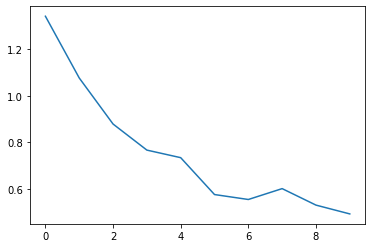

In [ ]:
NN_pre = NN_pre()

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(NN_pre.parameters(), lr = 0.001) 
train_loss = train_model(NN_pre, r_dataloader_train, loss, optimizer, n_epochs = 10, is_gru = False)

plt.plot(train_loss)

Test Accuracy: 0.6611111111111111
tensor([0.7446, 0.6400, 0.8402, 0.6302, 0.5178, 0.5952])
['baby products' 'beauty' 'grocery gourmet food' 'health personal care'
 'pet supplies' 'toys games']


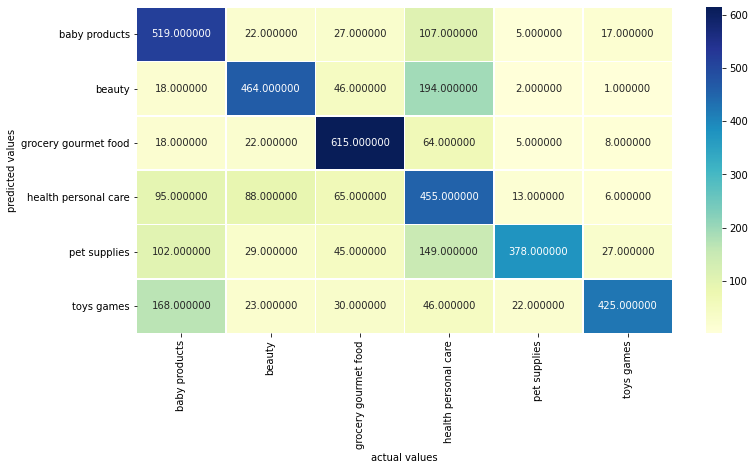

In [ ]:
nb_classes = len(le.classes_)
cm = conf_matrix(NN_pre, r_dataloader_test, nb_classes, is_gru = False)
print(cm.diag()/cm.sum(1)) #per-class accuracy
print(le.classes_)

Epoch: 0, loss: 1.2671974897384644
Epoch: 1, loss: 0.9698861837387085
Epoch: 2, loss: 0.7937297821044922
Epoch: 3, loss: 0.7787950038909912
Epoch: 4, loss: 0.6836400032043457
Epoch: 5, loss: 0.5745347738265991
Epoch: 6, loss: 0.5370815992355347
Epoch: 7, loss: 0.5231431722640991
Epoch: 8, loss: 0.5781450271606445
Epoch: 9, loss: 0.6147321462631226


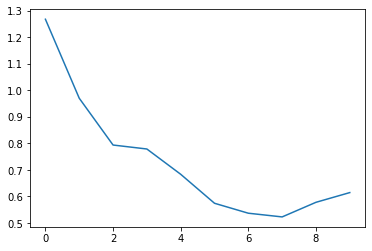

In [ ]:
# c
NN_pre = NN_pre()

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(NN_pre.parameters(), lr = 0.001) 
train_loss = train_model(NN_pre, r_dataloader_train_1, loss, optimizer, n_epochs = 10, is_gru = False)

plt.plot(train_loss)

Test Accuracy: 0.68125
tensor([0.5968, 0.8234, 0.7637, 0.4017, 0.7192, 0.7787])
['baby products' 'beauty' 'grocery gourmet food' 'health personal care'
 'pet supplies' 'toys games']


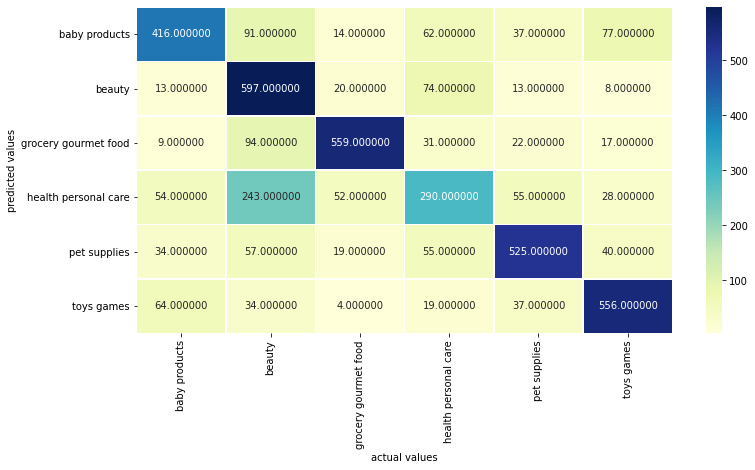

In [ ]:
nb_classes = len(le.classes_)
cm = conf_matrix(NN_pre, r_dataloader_test_1, nb_classes, is_gru = False)
print(cm.diag()/cm.sum(1)) #per-class accuracy
print(le.classes_)

### CNN (pretrained)

In [ ]:
class CNN(nn.Module):
    
    def __init__(self, *args):
        super().__init__()

        n_classes = len(le.classes_)
        self.maxlen = maxlen
        self.embedding = nn.Embedding(max_features, embed_dim)
        self.embedding = self.embedding.from_pretrained(glove.vectors)
        self.dropout = nn.Dropout(0.1)

        self.conv1 = nn.Sequential(
            nn.Conv1d(embed_dim, 32, 5),    
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),                                           
        )

        # self.conv2 = nn.Sequential(
        #     nn.Conv1d(100, 500, 5),    
        #     nn.BatchNorm1d(500),
        #     nn.ReLU(),
        #     nn.MaxPool1d(2),                                           
        # )

        self.layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(98*32, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, n_classes),
        )
                                          
    def forward(self, x): 
        #print(x.shape)
        out = self.embedding(x)
        #print(out.shape) 
        out = out.permute(0,2,1)
        #print(out.shape) 
        out = self.conv1(out)
        #print(out.shape) 
        out = self.dropout(out)
        # out = self.conv2(out)
        # out = self.dropout(out)
        out = self.layer(out)
        return out

Epoch: 0, loss: 0.5442927479743958
Epoch: 1, loss: 0.3872726559638977
Epoch: 2, loss: 0.3137229084968567
Epoch: 3, loss: 0.2526610493659973
Epoch: 4, loss: 0.23148204386234283
Epoch: 5, loss: 0.21657371520996094
Epoch: 6, loss: 0.20173530280590057
Epoch: 7, loss: 0.18684491515159607
Epoch: 8, loss: 0.15859271585941315
Epoch: 9, loss: 0.22197981178760529


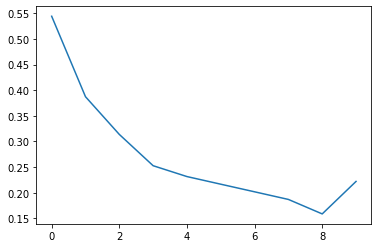

In [ ]:
# без 
CNN_pre = CNN()

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(CNN_pre.parameters(), lr = 0.001) 
train_loss = train_model(CNN_pre, r_dataloader_train, loss, optimizer, n_epochs = 10, is_gru = False)

plt.plot(train_loss)

Test Accuracy: 0.7421992954202316
tensor([0.7111, 0.7180, 0.7083, 0.6679, 0.8123, 0.8181])
['baby products' 'beauty' 'grocery gourmet food' 'health personal care'
 'pet supplies' 'toys games']


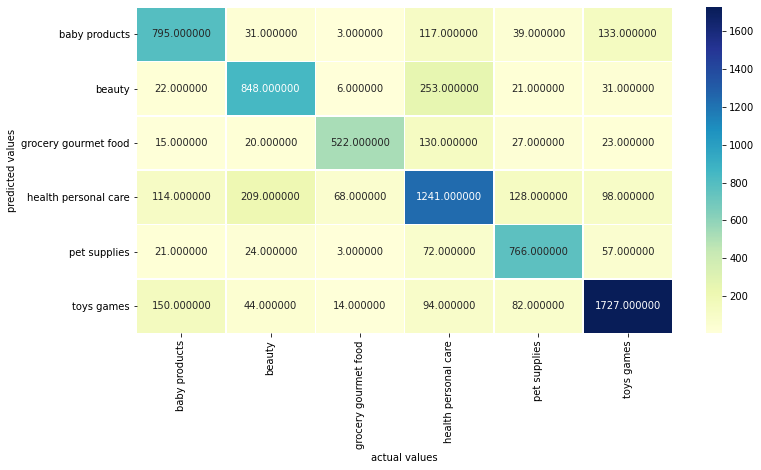

In [ ]:
nb_classes = len(le.classes_)
cm = conf_matrix(CNN_pre, r_dataloader_test, nb_classes, is_gru = False)
print(cm.diag()/cm.sum(1)) #per-class accuracy
print(le.classes_)

Epoch: 0, loss: 0.9507226347923279
Epoch: 1, loss: 0.8202450275421143
Epoch: 2, loss: 0.7664800882339478
Epoch: 3, loss: 0.7072222828865051
Epoch: 4, loss: 0.5687263011932373
Epoch: 5, loss: 0.5845157504081726
Epoch: 6, loss: 0.5535616278648376
Epoch: 7, loss: 0.4696933925151825
Epoch: 8, loss: 0.4352426826953888
Epoch: 9, loss: 0.5087505578994751


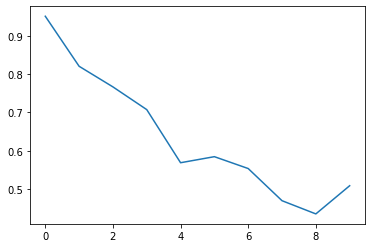

In [ ]:
# c 
CNN_pre = CNN()

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(CNN_pre.parameters(), lr = 0.001) 
train_loss = train_model(CNN_pre, r_dataloader_train_1, loss, optimizer, n_epochs = 10, is_gru = False)

plt.plot(train_loss)

Test Accuracy: 0.7395833333333334
tensor([0.6858, 0.7738, 0.8074, 0.6066, 0.7178, 0.8445])
['baby products' 'beauty' 'grocery gourmet food' 'health personal care'
 'pet supplies' 'toys games']


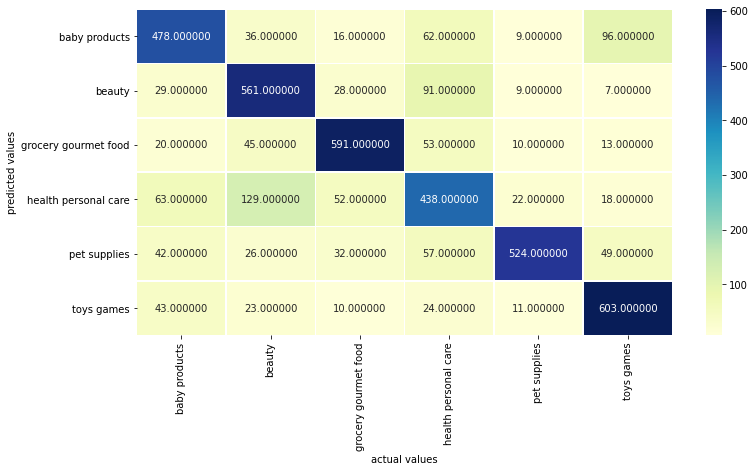

In [ ]:
nb_classes = len(le.classes_)
cm = conf_matrix(CNN_pre, r_dataloader_test_1, nb_classes, is_gru = False)
print(cm.diag()/cm.sum(1)) #per-class accuracy
print(le.classes_)

### GRU (pretrained)


In [ ]:
class GRU(nn.Module):
    def __init__(self, *args):
        super().__init__()
        
        hid = 64
        n_classes = len(le.classes_)
        self.maxlen = maxlen
        self.embedding = nn.Embedding(max_features, embed_dim)
        self.embedding = self.embedding.from_pretrained(glove.vectors)
        
        self.gru = nn.GRU(embed_dim, hid, num_layers = 1, batch_first = True) 
        
        self.layer1 = nn.Sequential(
            nn.Linear(hid, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, n_classes),

        )

    def forward(self, x):
        out = self.embedding(x)
        out, h = self.gru(out)
        out = self.layer1(out[:,-1]) 

        return out, h


Epoch: 0, loss: 0.42791664600372314
Epoch: 1, loss: 0.28003451228141785
Epoch: 2, loss: 0.11925020068883896
Epoch: 3, loss: 0.19955149292945862
Epoch: 4, loss: 0.14495758712291718
Epoch: 5, loss: 0.0846480056643486
Epoch: 6, loss: 0.07908818870782852
Epoch: 7, loss: 0.10106189548969269
Epoch: 8, loss: 0.09314945340156555
Epoch: 9, loss: 0.07374335825443268


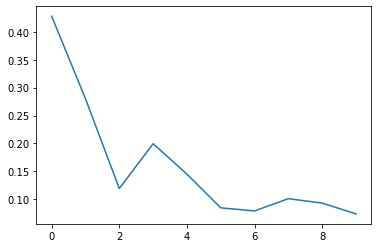

In [ ]:
# без
GRU_pre = GRU()

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(GRU_pre.parameters(), lr = 0.01) 
train_loss = train_model(GRU_pre, r_dataloader_train, loss, optimizer, n_epochs = 10, is_gru = True)
plt.plot(train_loss)


Test Accuracy: 0.8068696527428284
tensor([0.7612, 0.7519, 0.7232, 0.8283, 0.8600, 0.8484])
['baby products' 'beauty' 'grocery gourmet food' 'health personal care'
 'pet supplies' 'toys games']


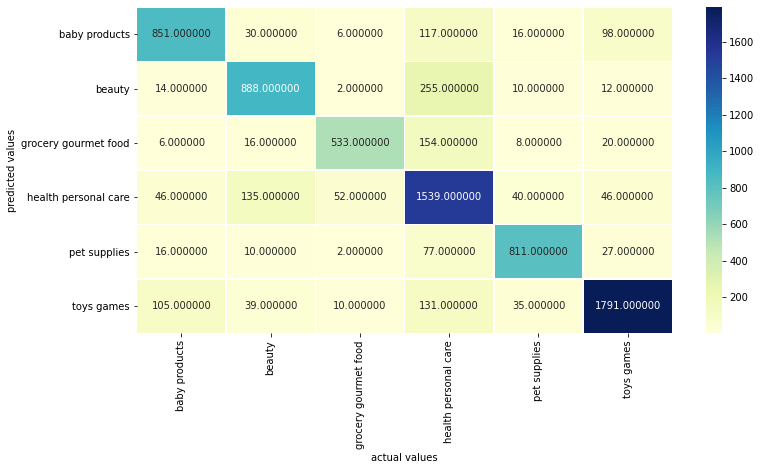

In [ ]:
nb_classes = len(le.classes_)
cm = conf_matrix(GRU_pre, r_dataloader_test, nb_classes, is_gru = True)
print(cm.diag()/cm.sum(1)) #per-class accuracy
print(le.classes_)

Epoch: 0, loss: 1.156331181526184
Epoch: 1, loss: 0.6325724124908447
Epoch: 2, loss: 0.5742791295051575
Epoch: 3, loss: 0.4812059700489044
Epoch: 4, loss: 0.44650012254714966
Epoch: 5, loss: 0.42602407932281494
Epoch: 6, loss: 0.3656293749809265
Epoch: 7, loss: 0.27544304728507996
Epoch: 8, loss: 0.3506249785423279
Epoch: 9, loss: 0.4406353831291199


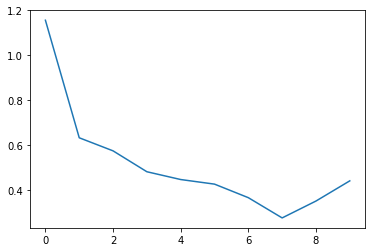

In [ ]:
# c 
GRU_pre = GRU()

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(GRU_pre.parameters(), lr = 0.01) 
train_loss = train_model(GRU_pre, r_dataloader_train_1, loss, optimizer, n_epochs = 10, is_gru = True)
plt.plot(train_loss)


Test Accuracy: 0.7935185185185185
tensor([0.8178, 0.7807, 0.8975, 0.6454, 0.8329, 0.7857])
['baby products' 'beauty' 'grocery gourmet food' 'health personal care'
 'pet supplies' 'toys games']


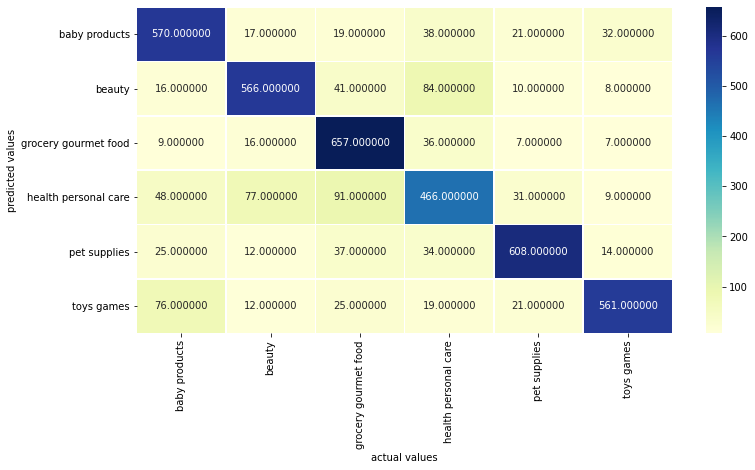

In [ ]:
nb_classes = len(le.classes_)
cm = conf_matrix(GRU_pre, r_dataloader_test_1, nb_classes, is_gru = True)
print(cm.diag()/cm.sum(1)) #per-class accuracy
print(le.classes_)

### RNN (pretrained)

In [151]:
class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        embed_dim = 16
        hid = 64

        self.embedding = nn.Embedding(max_features, embed_dim)

        self.rnn = nn.RNN(embed_dim, hid,
                            batch_first = True)  
        
        self.layer = nn.Sequential(
            nn.AvgPool1d(hid),
            nn.Dropout(0.4),
            nn.Flatten(),

            nn.Linear(200, 6)
            )
 
    def forward(self, x):
      out = self.embedding(x)
      out, h = self.rnn(out)
      out = input.unsqueeze(1)
      out = self.layer(out[:,-1])
 
      return out, h

Epoch: 0, loss: 1.4733954668045044
Epoch: 1, loss: 1.1256967782974243
Epoch: 2, loss: 1.0247360467910767
Epoch: 3, loss: 0.9645222425460815
Epoch: 4, loss: 0.8661240935325623


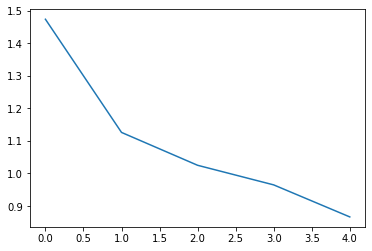

In [152]:
RNN_pre = RNN()

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(RNN_pre.parameters(), lr = 0.01) 
train_loss = train_model(RNN_pre, r_dataloader_train, loss, optimizer, n_epochs = 5, is_gru = True)
plt.plot(train_loss)

Test Accuracy: 0.5391293407146452
tensor([0.4392, 0.4615, 0.0312, 0.6475, 0.4517, 0.7565])
[0 1 2 3 4 5]


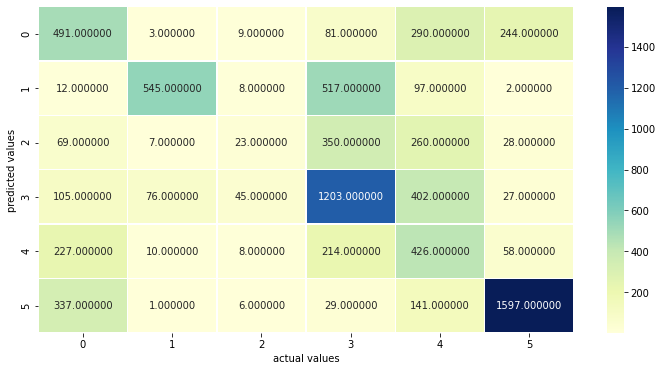

In [153]:
nb_classes = len(le.classes_)
cm = conf_matrix(RNN_pre, r_dataloader_test, nb_classes, is_gru = True)
print(cm.diag()/cm.sum(1)) #per-class accuracy
print(le.classes_)

### LSTM (pretrained)

In [124]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        embed_dim = 16
        hid = 64

        self.embedding = nn.Embedding(max_features, embed_dim)

        self.lstm = nn.LSTM(embed_dim, hid,
                            batch_first = True)  
        
        self.layer = nn.Sequential(
            nn.AvgPool1d(hid),
            nn.Dropout(0.4),
            nn.Flatten(),

            nn.Linear(200, 6)
            )
 
    def forward(self, x):
      out = self.embedding(x)
      out, h = self.rnn(out)
      out = input.unsqueeze(1)
      out = self.layer(out[:,-1])
 
      return out, h

Epoch: 0, loss: 0.768878698348999
Epoch: 1, loss: 0.4389573037624359
Epoch: 2, loss: 0.27430251240730286
Epoch: 3, loss: 0.12638084590435028
Epoch: 4, loss: 0.08555874973535538
Epoch: 5, loss: 0.0752866268157959
Epoch: 6, loss: 0.0394316092133522
Epoch: 7, loss: 0.02008717693388462
Epoch: 8, loss: 0.011993537656962872
Epoch: 9, loss: 0.007593443151563406


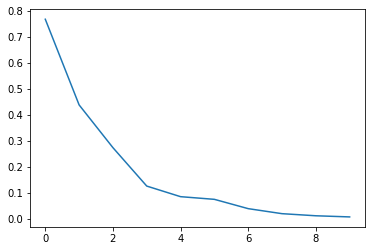

In [125]:
LSTM_pre = LSTM()

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(LSTM_pre.parameters(), lr = 0.01) 
train_loss = train_model(LSTM_pre, r_dataloader_train, loss, optimizer, n_epochs = 10, is_gru = True)
plt.plot(train_loss)

Test Accuracy: 0.7746602918973327
tensor([0.7442, 0.7824, 0.6839, 0.7287, 0.8282, 0.8347])
[0 1 2 3 4 5]


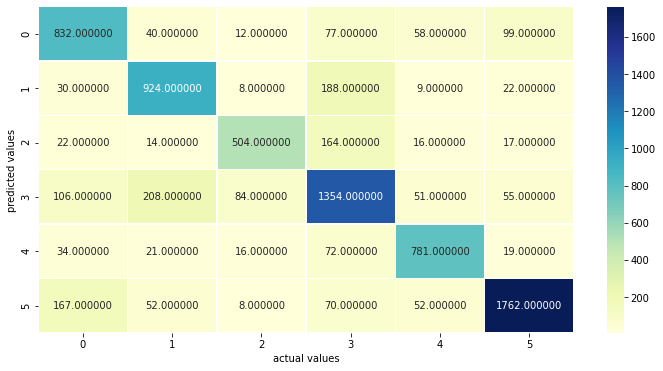

In [126]:
nb_classes = len(le.classes_)
cm = conf_matrix(LSTM_pre, r_dataloader_test, nb_classes, is_gru = True)
print(cm.diag()/cm.sum(1)) #per-class accuracy
print(le.classes_)



---



---

